<a href="https://colab.research.google.com/github/alexmacharia/deep_learning_projects/blob/main/8_Pytorch_Fashion_MNIST_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import PIL
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.optim as optim
import torch.nn as nn

print("GPU available: {}".format(torch.cuda.is_available()))

GPU available: True


In [2]:
device = 'cuda'

In [3]:
data_transforms = {
    'train': transforms.Compose([
        # Transforms are executed in the order they are called
        # Some transforms return color image hence the need to convert image back to grayscale
        transforms.RandomAffine(degrees=10, translate=(0.05,0.05), shear=5),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,)),

    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,),(0.5,))
    ])
}

In [4]:
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                             download=True, transform=data_transforms['train'])

testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                            download=True, transform=data_transforms['val'])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=True, num_workers=2)



100%|██████████| 26421880/26421880 [00:03<00:00, 8314179.67it/s] 


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 142197.19it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2590446.74it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 6435850.07it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3)
    self.conv1_bn = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.pool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(64 * 12 * 12, 128)
    self.fc2 = nn.Linear(128, 10)
    self.dropOut = nn.Dropout(0.2)

  def forward(self, x):
    x = F.relu(self.conv1_bn(self.conv1(x)))
    x = self.dropOut(x)
    x = self.dropOut(F.relu(self.conv2_bn(self.conv2(x))))

    x = self.pool(x)
    x = x.view(-1, 64 * 12 * 12)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x


net = Net()
net.to(device)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (dropOut): Dropout(p=0.2, inplace=False)
)

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [7]:
epochs = 15

epoch_log = []
loss_log = []
accuracy_log = []

for epoch in range(epochs):
  print(f'Starting Epoch: {epoch+1}...')

  running_loss = 0.0

  for i, data in enumerate(trainloader, 0):
    inputs, labels = data

    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    if i % 100 == 99:
      correct = 0
      total = 0

      with torch.no_grad():
        for data in testloader:
          images, labels = data

          images = images.to(device)
          labels = labels.to(device)

          outputs = net(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        epoch_num = epoch + 1
        actual_loss = running_loss / 50
        print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)}, Loss: {actual_loss:.3f}, Test Accuracy = {accuracy:.3f}%')
        running_loss = 0.0

  epoch_log.append(epoch_num)
  loss_log.append(actual_loss)
  accuracy_log.append(accuracy)

print('Finished Training')



Starting Epoch: 1...
Epoch: 1, Mini-Batches Completed: 100, Loss: 2.474, Test Accuracy = 72.780%
Epoch: 1, Mini-Batches Completed: 200, Loss: 1.582, Test Accuracy = 75.700%
Epoch: 1, Mini-Batches Completed: 300, Loss: 1.503, Test Accuracy = 75.200%
Epoch: 1, Mini-Batches Completed: 400, Loss: 1.402, Test Accuracy = 78.440%
Epoch: 1, Mini-Batches Completed: 500, Loss: 1.340, Test Accuracy = 78.400%
Epoch: 1, Mini-Batches Completed: 600, Loss: 1.293, Test Accuracy = 78.280%
Epoch: 1, Mini-Batches Completed: 700, Loss: 1.250, Test Accuracy = 80.750%
Epoch: 1, Mini-Batches Completed: 800, Loss: 1.173, Test Accuracy = 80.530%
Epoch: 1, Mini-Batches Completed: 900, Loss: 1.259, Test Accuracy = 80.030%
Epoch: 1, Mini-Batches Completed: 1000, Loss: 1.137, Test Accuracy = 81.670%
Epoch: 1, Mini-Batches Completed: 1100, Loss: 1.139, Test Accuracy = 81.840%
Epoch: 1, Mini-Batches Completed: 1200, Loss: 1.146, Test Accuracy = 80.780%
Epoch: 1, Mini-Batches Completed: 1300, Loss: 1.102, Test Accura

In [9]:
correct = 0
total = 0

with torch.no_grad():
  for data in testloader:
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the network on the 10000 test images: {accuracy:.4}%')

Accuracy of the network on the 10000 test images: 89.61%


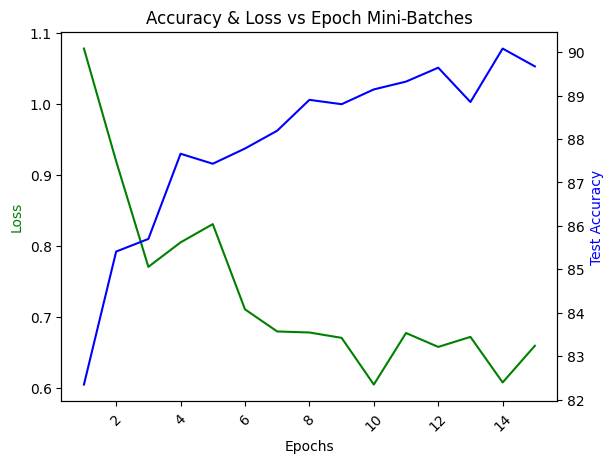

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

plt.title("Accuracy & Loss vs Epoch Mini-Batches")
plt.xticks(rotation=45)

ax2 = ax1.twinx()

ax1.plot(epoch_log, loss_log, 'g-')
ax2.plot(epoch_log, accuracy_log, 'b-')

ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss', color='g')
ax2.set_ylabel('Test Accuracy', color='b')

plt.show()